In [1]:
#STEP 1: Import packages
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
#import geopandas
#import geopandas as gpd
#from geopandas.geodataframe import GeoDataFrame
#from shapely.geometry import Point
#from mpl_toolkits.basemap import Basemap
from heapq import nlargest

#import mySQL option 1
import mysql.connector

#import mySQL option 2
#import pymysql.cursors #only try this after running the "python -m pip install PyMySQL" 

In [2]:
#STEP 2: Setting the cnx
#cnx for option 1
cnx = mysql.connector.connect(user='epa1351g14', password='xgt65RR##', database='epa1351group14')
#cnx for option 2
#cnx = pymysql.connect(user='epa1351g14', password='xgt65RR##', database='epa1351group14')

Definitions for dataframes

In [3]:
#STEP 3a: Definition for reading in dataframe of segmenttraveltimes
def read_stt_sql(cnx):
    cursor = cnx.cursor()
   
    query_stt = ("SELECT * from segmenttraveltimes ORDER BY RowID2")
    segmenttraveltimes = pd.read_sql(query_stt,cnx)
    
    return segmenttraveltimes

In [4]:
#STEP 3b: Definition for reading in dataframe of brokenbridges
def read_bb_sql(cnx):
    cursor = cnx.cursor()

    query_bb = ("SELECT * from brokenbridges ORDER BY RowID3")
    brokenbridges = pd.read_sql(query_bb,cnx)
    
    return brokenbridges

Definitions for visualizations

In [5]:
#constant values for segmenttraveltimes
LN1 = list()
LDC = list()
N1DC = pd.read_csv('Data_clean_N1_Dhaka_Chittagong_new.csv')
LRPsDhakaChittagong = list(N1DC.LRPName.unique())

In [ ]:
#constant values for brokenbridges
bridges = pd.read_csv('Bridge_data_with_link_to_traffic.csv')
shape = gpd.read_file('bgd_admbnda_adm0_bbs_20180410/bgd_admbnda_adm0_bbs_20180410.shp')
bridges=bridges[bridges['road']=='N1']
#Make coordinates from the latitude and longitude
bridges['Coordinates'] = list(zip(bridges.lon, bridges.lat))
bridges['Coordinates'] = bridges['Coordinates'].apply(Point)
bridges = GeoDataFrame(bridges, geometry='Coordinates')
shape.crs = {'init': 'epsg:4326'}
bridges.crs = {'init': 'epsg:4326'}
fig, ax = plt.subplots(1, figsize=(3.5,7))
base = shape.plot(ax=ax, color='#DCDCDC')
bridges.plot(ax=base, marker='o', alpha=0.5, color = 'green', markersize = 1)

In [6]:
def movingaverage(segmenttraveltimes):
    dfma = segmenttraveltimes[segmenttraveltimes.LRPName.isin(LRPsDhakaChittagong)]
    LN1.append(segmenttraveltimes.SegTime.sum()/len(segmenttraveltimes))
    LDC.append(dfma.SegTime.sum()/len(dfma))
    x = list(range(1,len(LN1)+1))
    
    #clear_output()
    plt.plot(x, LN1)
    plt.plot(x, LDC)
    ma = plt.figure(1)
    return ma

In [ ]:
def vehiclespersegment(segmenttraveltimes):
    n = 5
    segments = segmenttraveltimes.LRPName.unique()
    vehicles = segmenttraveltimes.VehicleType.unique()
    segmentdict = {}
    for segment in segments:
        df = segmenttraveltimes[segmenttraveltimes.LRPName == segment]
        vehicledict = {}
        for vehicle in vehicles:
            df2 = df[df.VehicleType == vehicle]
            segtimepervehicle = df2.SegTime.sum()
            vehicledict[vehicle] = segtimepervehicle
            segmentdict[segment] = vehicledict

    newdict = {}
    for key, value in segmentdict.items():
        newdict[key] = sum(segmentdict[key].values())
    highestsegment = nlargest(n, newdict, key=newdict.get)
    highestsegmentdict = {}
    for segment in highestsegment:
        highestsegmentdict[segment] = segmentdict[segment]

    df = pd.DataFrame(highestsegmentdict)
    clear_output()
    df.plot(kind="bar", stacked=True)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    vps = plt.figure(2)
    vps.show()
    return vps

In [ ]:
def vehicletypes(segmenttraveltimes):
    n = 10
    segmenttraveltimes[segmenttraveltimes.LRPName.isin(list(segmenttraveltimes.groupby('LRPName')['SegTime'].sum().nlargest(n).to_dict().keys()))].groupby(['LRPName','VehicleType'])['SegTime'].sum().unstack().plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.1, 1.05))
    
    clear_output()
    vt = plt.figure(3)
    vt.show()
    return vt

In [ ]:
def bridgesdown(brokenbridges):
    clear_output()
    bridgesbrokendown = brokenbridges.BridgeID.unique()
    brokenbridges = bridges[bridges.LRPName.isin(bridgesbrokendown)]
    brokenbridges.plot(ax=base, marker = 'o', alpha = 0.5, color = 'red', markersize = 100)
    ax.set_title("Bridges broken down in red")
    return

Definition for the updating visualisations

In [7]:
#STEP 5: Definition to update all the visualisations
def wait_for_sql():
    last_rowid = -1
    while True:
        #cnx for option 1
        cnx = mysql.connector.connect(user='epa1351g14', password='xgt65RR##', database='epa1351group14')
        #cnx for option 2
        #cnx = pymysql.connect(user='epa1351g14', password='xgt65RR##', database='epa1351group14')
        cursor = cnx.cursor()
        
        #selecting the latest row in hourlyupdate table
        query = ("SELECT * from hourlyupdate ORDER BY RowID1 DESC LIMIT 1")
        cursor.execute(query)

#for loop searching for a new row in the hourlyupdate table        
        for (RowID1, SimioHour) in cursor:
            if RowID1 > last_rowid:
                #Reading in the dataframes
                read_stt_sql(cnx)
                segmenttraveltimes = read_stt_sql(cnx)
                read_bb_sql(cnx)
                brokenbridges = read_bb_sql(cnx)
                print('voor')
                #Visualisations
                ma = movingaverage(segmenttraveltimes)
                ma.show()
                print('na')
                #vehiclespersegment(segmenttraveltimes)
                #vehicletypes(segmenttraveltimes)
                #bridgesdown(brokenbridges)
                #change the value of last_rowid to the current Row ID
                last_rowid = RowID1
        time.sleep(1)

voor


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


na
voor
na


KeyboardInterrupt: 

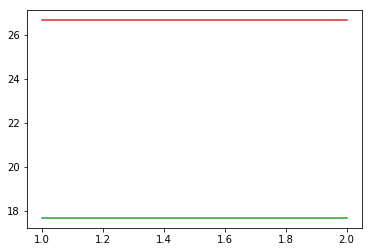

In [8]:
wait_for_sql()